<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/munich/embeddings/gen_description_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Descriptions

In [1]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1157, done.
remote: Counting objects: 100% (1157/1157), done.
remote: Compressing objects: 100% (1095/1095), done.
remote: Total 1157 (delta 692), reused 304 (delta 55), pack-reused 0
Receiving objects: 100% (1157/1157), 9.92 MiB | 9.63 MiB/s, done.
Resolving deltas: 100% (692/692), done.


In [2]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut
import train_utils as train
device = ut.get_device()

/content/airbnb_price
cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB


In [3]:
%%capture
!pip install transformers
!pip install requests
!pip install captum

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import fastprogress
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertModel
import torch.nn as nn
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

### Explore the dataset

In [5]:
path = "/content/drive/MyDrive/Colab/airbnb/munich/language/train.pickle"
data = pd.read_pickle(path)
input_ids, attention_masks, labels = data['desc_input_ids'], data['desc_attention_masks'], data['log_price']

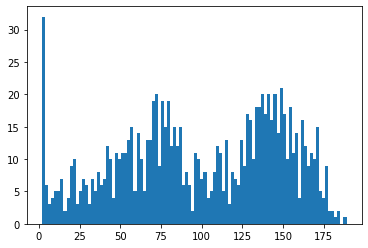

In [6]:
# TODO Visualize the length of the reviews in your dataset
def count_words(string):
    return len(string.split())

review_lengths = np.vectorize(count_words)(data['description_en'])

a = plt.hist(review_lengths, bins = 100)
plt.show()

In [7]:
%tensorflow_version 1.x
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

TensorFlow 1.x selected.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
ids = np.stack(input_ids)
labels = np.stack(labels)
masks = np.stack(attention_masks)

## Create DataLoader

You can use `TensorDataset`, `torch.from_numpy(...)`, and `DataLoader(...)` to create Dataloaders for your dataset holding features, labels and attention masks. Make sure to shuffle your training data. Is shuffling required for the validation and test data?

In [9]:
# TODO
# create dataloaders
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(torch.from_numpy(ids), torch.from_numpy(labels), torch.from_numpy(masks))
dataloader = DataLoader(dataset, shuffle=False, num_workers=2, batch_size=128)

# Generate Embeddings

In [10]:
# load model
sys.path.append("/content/airbnb_price/models")
from language_model import LanguageBertNet
model = LanguageBertNet(fine_tune=True, with_attention_masks=True)
path = "/content/drive/MyDrive/Colab/airbnb/data/logs/description/best/checkpoints/checkpoint.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# generate embeddings
from tqdm import tqdm
embeddings = torch.empty((len(dataset), 100))
model.eval()
start = 0
indices = []
with torch.no_grad():
    for ids, index, masks in tqdm(dataloader):
        ids, masks = ids.to(device), masks.to(device)
        embedding = model.genembeddings(ids, masks)
        embedding = embedding.detach().cpu()
        stop = start + len(ids)
        embeddings[start:stop] = embedding
        start = stop
        indices = indices + list(index.numpy())

100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


In [12]:
# save embeddings in pandas dataframe
embeddings[embeddings < 0] = 0
df = pd.Series(embeddings.numpy().tolist(), name="descriptions", index=indices)
path = "/content/drive/MyDrive/Colab/airbnb/munich/embeddings/descriptions.pickle"
df.to_pickle(path)

In [13]:
price = data["log_price"].to_numpy()
dataset = TensorDataset(torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(df)[:, np.newaxis])),
                        torch.tensor(price))
dataloader = DataLoader(dataset, batch_size=128)

100%|██████████| 8/8 [00:00<00:00, 160.87it/s]


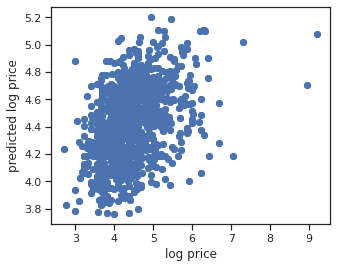

(array([0.3873213296085121], dtype=object), 4.552930645086156e-37)
The root mean squared error (MSE) on test set: 0.6427


In [43]:
# show correlation
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

ys = []
ypreds = []

with torch.no_grad():
    model = model.eval()

    for embeddings, labels in tqdm(dataloader):
        embeddings = embeddings.to(device).float()
        y_pred = model.prediction_from_mean(embeddings)
        y_pred = list(y_pred.detach().cpu().numpy())
        ypreds = ypreds + y_pred

        ys = ys + list(labels)

ys = np.array(ys)
ypreds = np.array(ypreds)
m = np.mean(ypreds)
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(ypreds, ys)
ypreds = ypreds * reg.coef_ + reg.intercept_ 
plt.figure(figsize=(5,4))
sns.set(style="ticks")
plt.scatter(ys, ypreds, c='#1f77b4')
plt.ylabel("predicted log price")
plt.xlabel("log price")
plt.scatter(ys, ypreds)
plt.savefig(str("/content/file0.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()
print(pearsonr(ys, ypreds))


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys, ypreds)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

In [20]:
print(reg.intercept_, reg.coef_)

1.9549041 [0.60061556]


In [39]:
ypreds

array([4.5804024, 4.280608 , 3.9751205, 4.1153846, 4.0540695, 4.032804 ,
       4.4531517, 4.541872 , 3.7398486, 4.6289344, 3.723716 , 4.4198174,
       3.3659801, 4.050956 , 4.026059 , 3.5794399, 4.7988114, 3.7957618,
       4.593045 , 4.1128206, 4.446609 , 4.097125 , 4.1044974, 4.0684776,
       4.6851373, 4.1017256, 4.500895 , 3.7181482, 3.8992386, 3.9281595,
       4.233194 , 4.067055 , 3.9578018, 4.9072924, 3.9778867, 4.3473663,
       4.1392536, 3.8600585, 4.524637 , 3.8814673, 3.5007641, 3.7570245,
       3.6279044, 3.7116144, 4.373026 , 3.435082 , 3.6618452, 3.4164517,
       3.59459  , 3.3173811, 3.682251 , 3.867712 , 4.297894 , 4.5640564,
       4.237868 , 4.5853844, 4.053966 , 5.016529 , 3.260788 , 3.3990746,
       5.088754 , 3.8739285, 3.3492856, 3.9555511, 3.87944  , 3.0665598,
       3.794102 , 3.5890799, 3.0122097, 4.2298903, 3.3971171, 4.702963 ,
       3.5205777, 3.7803319, 4.5615897, 4.5261703, 4.238818 , 4.9027443,
       4.6623344, 4.3378553, 4.1668434, 3.8016553, 